<a href="https://colab.research.google.com/github/SanjayGanapathy/StudySync-Outlier-Detection/blob/main/Fitbit_Anomaly_Detection_(Colab_Notebook).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Generated 232 Tier-1 events (pre-postprocessing)
Events after streak collapsing and same-day de-dup: 124
Review summary (first 20 rows):
        Id                                               AlertType DecisionStatus  Count
1503960366          Off-Wrist Overnight (Likely Not Worn at Night)        Pending      5
1503960366                                      No Wear (Full Day)        Pending      1
1624580081                                Low Night Coverage (14d)        Pending      1
1644430081                                Low Night Coverage (14d)        Pending      1
1844505072                                      No Wear (Full Day)        Pending     12
1927972279                                      No Wear (Full Day)        Pending     13
2022484408                                Low Night Coverage (14d)        Pending      1
2026352035          Off-Wrist Overnight (Likely Not Worn at Night)        Pending      3
2320127002                                Low Night Coverage (

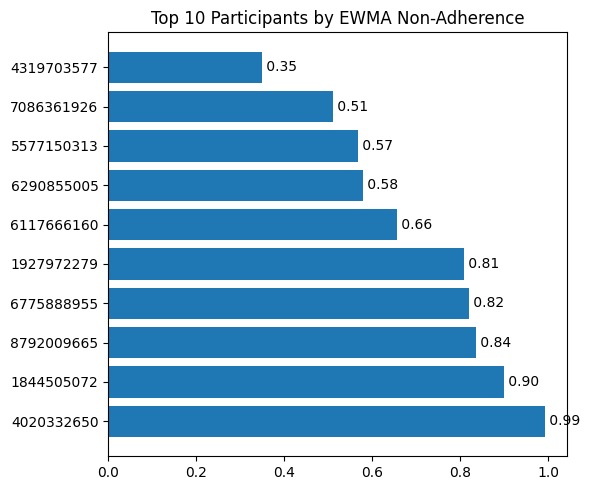

Top by EWMA: Id
4020332650    0.993183
1844505072    0.899778
8792009665    0.835478


/tmp/ipython-input-648286198.py:660: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout(); plt.show()


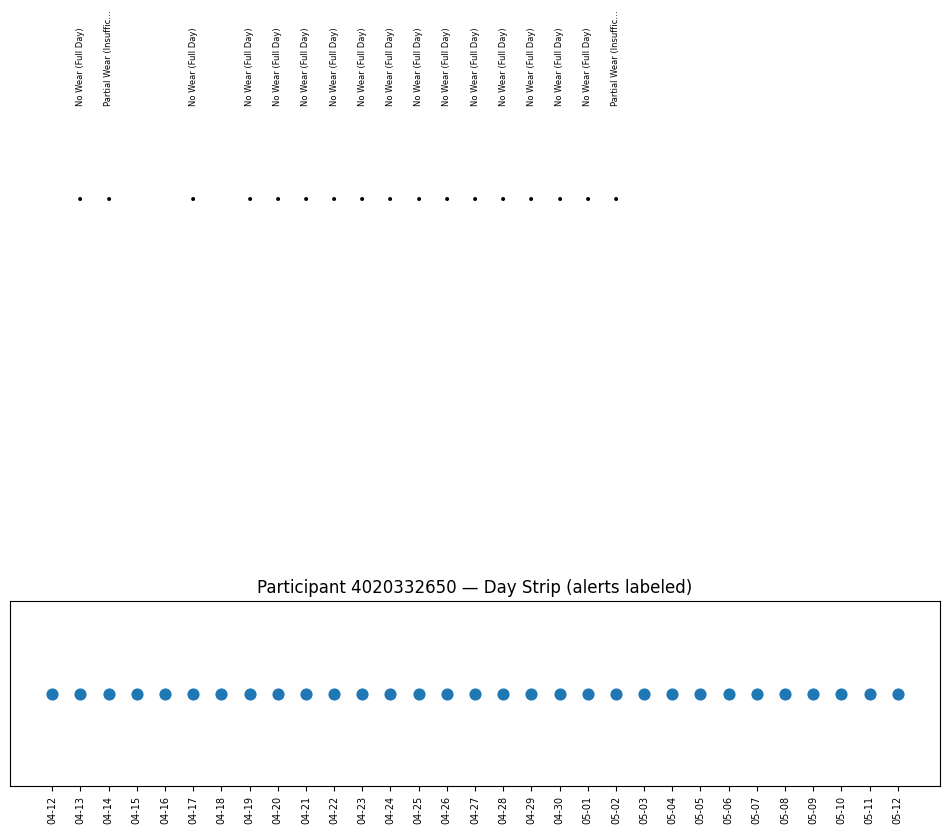

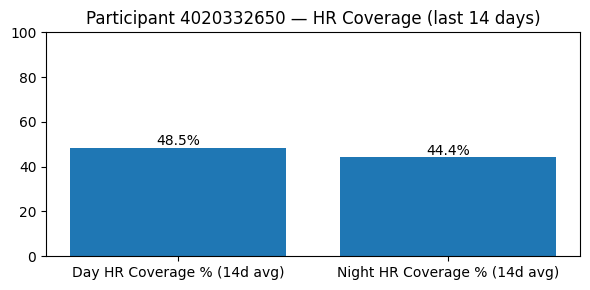

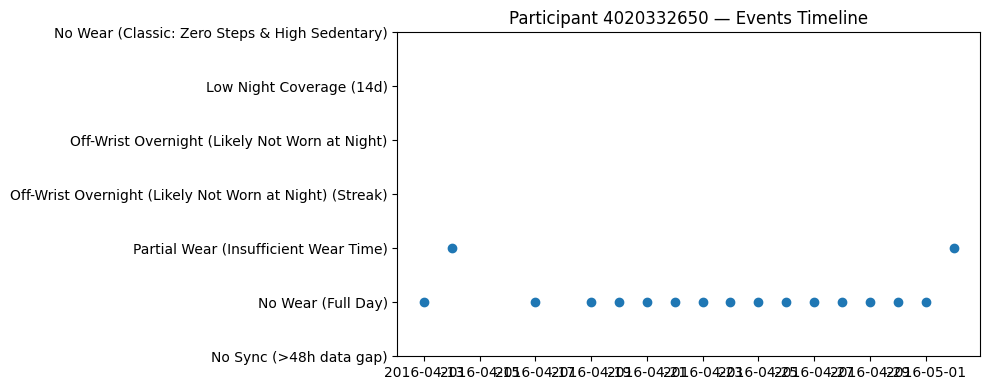

/tmp/ipython-input-648286198.py:660: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout(); plt.show()


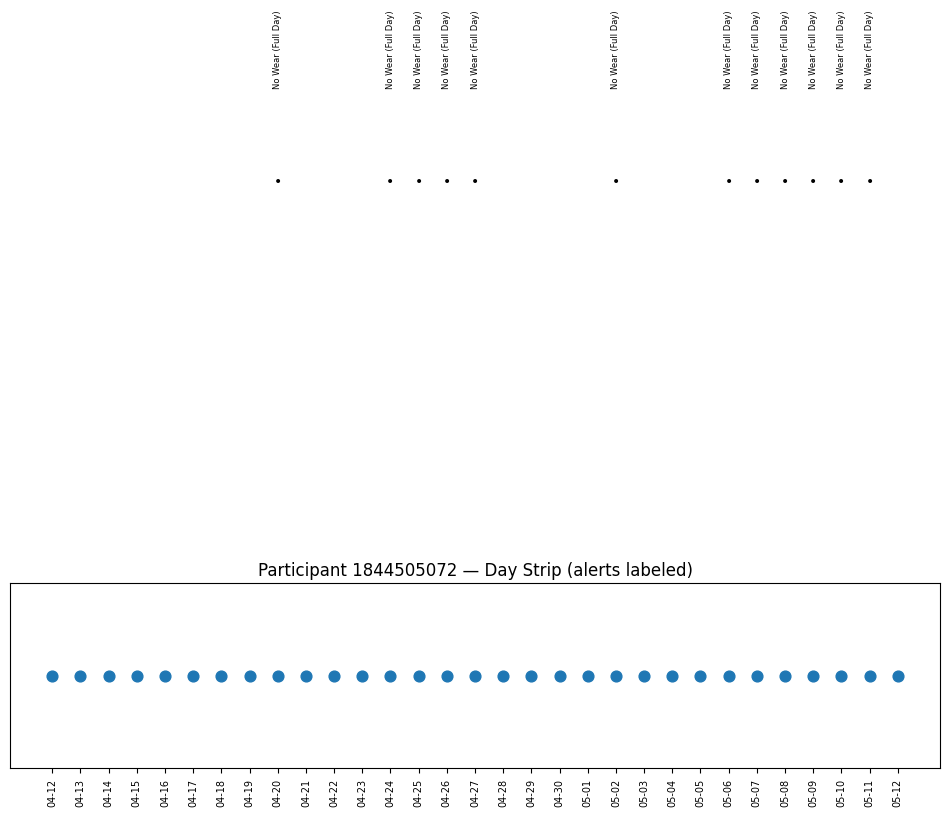

No HR coverage for 1844505072


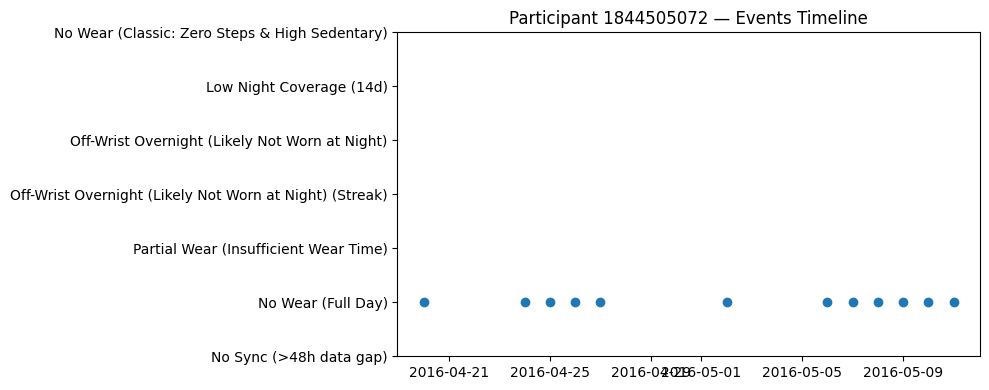

/tmp/ipython-input-648286198.py:660: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout(); plt.show()


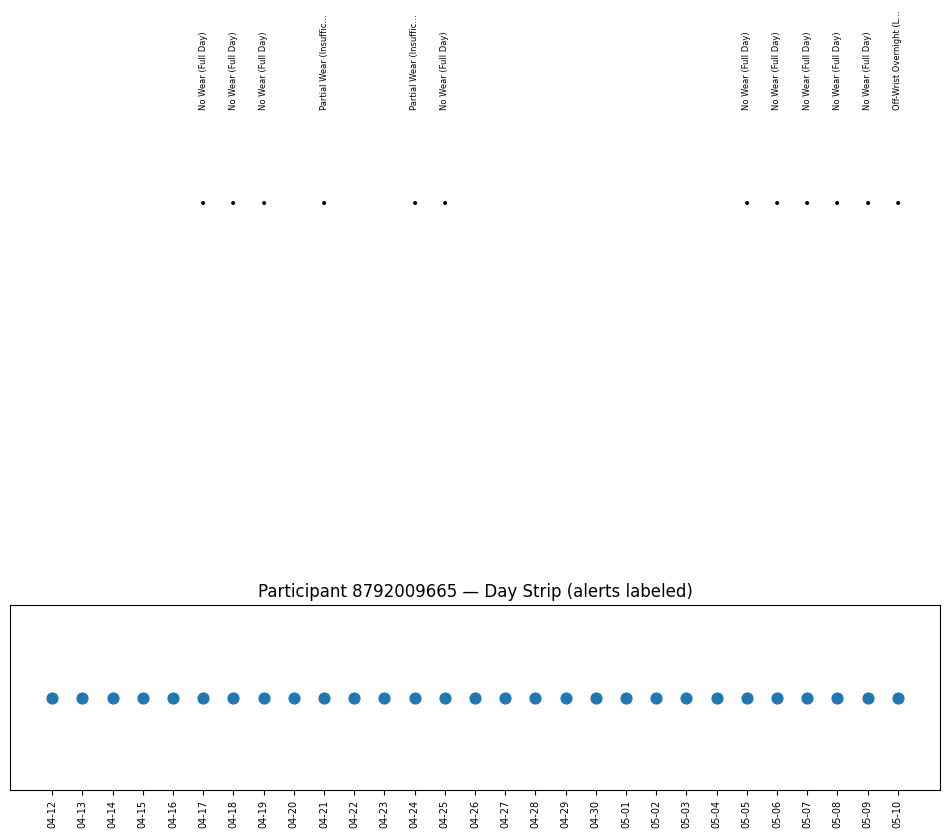

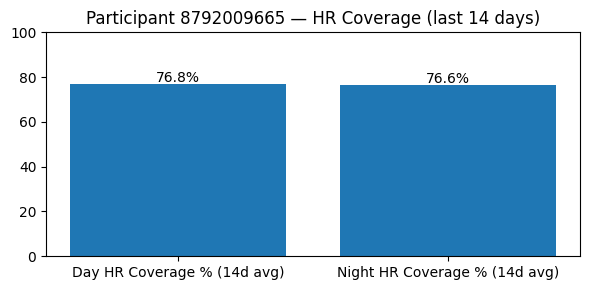

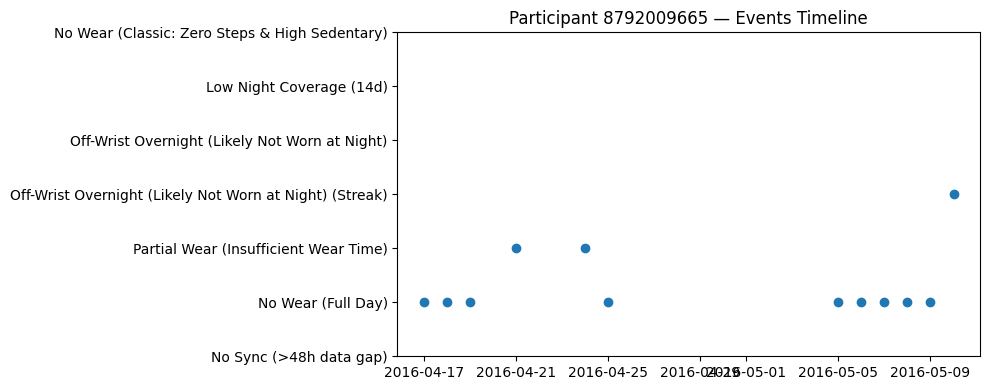

In [ ]:
# ================================================
# Tier 1 Deterministic Non-Adherence Expert System (Colab-ready)
# Author: you
# Requirements: pandas, numpy, matplotlib
# ================================================

import os
import json
import uuid
from dataclasses import dataclass
from typing import Dict, List, Optional, Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -------------------------
# Config
# -------------------------
@dataclass
class Tier1Config:
    # No-sync (data gap) threshold
    nosync_gap_hours: int = 48

    # Day-level "no-wear" heuristics (ALL true -> Full Day No Wear)
    no_wear_steps_max: int = 50
    no_wear_total_active_minutes_max: int = 5
    no_wear_distance_max_km: float = 0.2
    no_wear_hr_minutes_max: int = 60
    no_wear_high_sedentary_minutes_min: int = 1000

    # Partial wear
    partial_wear_min_hr_minutes: int = 600
    partial_wear_min_steps: int = 500

    # Overnight window + thresholds
    nocturnal_start_hour: int = 22
    nocturnal_end_hour: int = 8
    nocturnal_min_hr_minutes: int = 120
    min_habitual_sleep_logs: int = 10

    # Classic rule
    classic_zero_steps_high_sedentary_sedentary_min: int = 1000

    # Priority labels
    priority_critical: str = "Critical"

    # Optional HR CSV rows limit
    max_hr_rows: Optional[int] = None

    # Minimum days for gap eval
    min_days_for_gap_eval: int = 3

    # Streak + cadence
    overnight_min_streak_nights: int = 2
    contact_cadence_hours: int = 72

    # Same-day de-dupe priority
    dedup_priority_order: List[str] = None

    # Rolling night coverage “tendency”
    night_coverage_window_days: int = 14
    night_coverage_threshold: float = 0.15  # <15% nights logged

    # EWMA risk score
    ewma_beta: float = 0.3
    score_weights: Dict[str, float] = None  # map alert -> x_t weight

CONFIG = Tier1Config()
if CONFIG.dedup_priority_order is None:
    CONFIG.dedup_priority_order = [
        "No Sync (>48h data gap)",
        "No Wear (Full Day)",
        "Partial Wear (Insufficient Wear Time)",
        "Off-Wrist Overnight (Likely Not Worn at Night) (Streak)",
        "Off-Wrist Overnight (Likely Not Worn at Night)",
        "Low Night Coverage (14d)",
        "No Wear (Classic: Zero Steps & High Sedentary)",
    ]
if CONFIG.score_weights is None:
    CONFIG.score_weights = {
        "No Wear (Full Day)": 1.0,
        "No Sync (>48h data gap)": 1.0,
        "Partial Wear (Insufficient Wear Time)": 0.5,
        "Off-Wrist Overnight (Likely Not Worn at Night)": 0.4,
        "Off-Wrist Overnight (Likely Not Worn at Night) (Streak)": 0.4,
        "Low Night Coverage (14d)": 0.6,
        "No Wear (Classic: Zero Steps & High Sedentary)": 1.0,
    }

# -------------------------
# Utils
# -------------------------
def _read_csv_if_exists(path: str, **kwargs) -> Optional[pd.DataFrame]:
    return pd.read_csv(path, **kwargs) if os.path.exists(path) else None

def _parse_date(s, fmt: Optional[str] = None):
    return pd.to_datetime(s, errors="coerce", format=fmt) if fmt else pd.to_datetime(s, errors="coerce")

def _to_date(x: pd.Series) -> pd.Series:
    return pd.to_datetime(x.dt.date)

def _night_window_mask(ts: pd.Series, start_hour: int, end_hour: int) -> pd.Series:
    hours = ts.dt.hour
    return ((hours >= start_hour) & (hours < end_hour)) if start_hour < end_hour else ((hours >= start_hour) | (hours < end_hour))

def _night_window_minutes(cfg: Tier1Config) -> int:
    if cfg.nocturnal_start_hour < cfg.nocturnal_end_hour:
        return int((cfg.nocturnal_end_hour - cfg.nocturnal_start_hour) * 60)
    left = 24 - cfg.nocturnal_start_hour
    return int((left + cfg.nocturnal_end_hour) * 60)

# -------------------------
# Load & Normalize Fitbit Data
# -------------------------
def load_fitbit_data(data_dir: str) -> Dict[str, pd.DataFrame]:
    """
    Loads Fitbit CSVs from the Kaggle dataset directory (arashnic/fitbit) and normalizes key columns.
    Returns dict with keys: daily, sleep, hr (some may be None).
    """
    daily = _read_csv_if_exists(os.path.join(data_dir, "dailyActivity_merged.csv"))
    sleep = _read_csv_if_exists(os.path.join(data_dir, "sleepDay_merged.csv"))
    hr = _read_csv_if_exists(os.path.join(data_dir, "heartrate_seconds_merged.csv"), nrows=CONFIG.max_hr_rows)

    # DAILY
    if daily is not None:
        daily = daily.rename(columns={"ActivityDate": "ActivityDate", "Id": "Id"})
        daily["ActivityDate"] = _parse_date(daily["ActivityDate"], fmt="%m/%d/%Y")
        num_cols = daily.select_dtypes(include=[np.number]).columns
        daily[num_cols] = daily[num_cols].fillna(0)
        act_min_cols = [c for c in ["VeryActiveMinutes","FairlyActiveMinutes","LightlyActiveMinutes"] if c in daily]
        daily["TotalActiveMinutes"] = daily[act_min_cols].sum(axis=1) if act_min_cols else 0
        daily["Date"] = _to_date(daily["ActivityDate"])
        # enforce one row per Id-Date
        daily = (daily.sort_values(["Id","Date"])
                      .groupby(["Id","Date"], as_index=False)
                      .first())

    # SLEEP
    if sleep is not None:
        sleep["SleepDay"] = _parse_date(sleep["SleepDay"], fmt="%m/%d/%Y %I:%M:%S %p")
        sleep["Date"] = _to_date(sleep["SleepDay"])
        # Some participants have multiple logs in a day → dedup to a single flag per Id-Date
        sleep = (sleep.sort_values(["Id","Date"])
                      .groupby(["Id","Date"], as_index=False)
                      .agg(TotalSleepRecords=("TotalSleepRecords","sum"),
                           TotalMinutesAsleep=("TotalMinutesAsleep","sum"),
                           TotalTimeInBed=("TotalTimeInBed","sum")))

    # HEART RATE (seconds)
    if hr is not None:
        if "Time" in hr:
            hr["Time"] = _parse_date(hr["Time"])
        elif "DateTime" in hr:
            hr["Time"] = _parse_date(hr["DateTime"])
        else:
            raise ValueError("Heart rate file missing 'Time' or 'DateTime' column.")
        hr = hr.loc[hr["Time"].notna()].copy()
        hr["Date"] = _to_date(hr["Time"])

    return {"daily": daily, "sleep": sleep, "hr": hr}

# -------------------------
# Feature Engineering
# -------------------------
def compute_hr_coverage(hr: Optional[pd.DataFrame]) -> Optional[pd.DataFrame]:
    if hr is None or hr.empty:
        return None
    hr["Minute"] = hr["Time"].dt.floor("min")
    cov_day = (hr.groupby(["Id", "Date"])["Minute"].nunique().reset_index(name="HRMinutes"))
    night_mask = _night_window_mask(hr["Time"], CONFIG.nocturnal_start_hour, CONFIG.nocturnal_end_hour)
    hr_night = hr.loc[night_mask].copy()
    if not hr_night.empty:
        hr_night["Minute"] = hr_night["Time"].dt.floor("min")
        cov_night = (hr_night.groupby(["Id","Date"])["Minute"].nunique().reset_index(name="HRMinutesNight"))
    else:
        cov_night = pd.DataFrame(columns=["Id","Date","HRMinutesNight"])
    cov = pd.merge(cov_day, cov_night, on=["Id","Date"], how="left")
    cov["HRMinutesNight"] = cov["HRMinutesNight"].fillna(0).astype(int)
    cov["HRMinutes"] = cov["HRMinutes"].astype(int)
    return cov

def compute_sleep_habits(sleep: Optional[pd.DataFrame]) -> Optional[pd.DataFrame]:
    if sleep is None or sleep.empty:
        return None
    # Count distinct dates with any sleep for each Id
    return sleep.groupby("Id")["Date"].nunique().reset_index(name="SleepLogDays")

def detect_data_gaps(daily: Optional[pd.DataFrame]) -> Optional[pd.DataFrame]:
    if daily is None or daily.empty:
        return None
    out = []
    for pid, g in daily.groupby("Id"):
        g = g.sort_values("Date")
        if len(g) < CONFIG.min_days_for_gap_eval:
            continue
        dates = pd.to_datetime(g["Date"]).dt.normalize().tolist()
        for i in range(1, len(dates)):
            gap = (dates[i] - dates[i-1]).total_seconds() / 3600.0
            if gap > CONFIG.nosync_gap_hours:
                out.append({"Id": pid, "GapStartDate": dates[i-1], "GapEndDate": dates[i], "GapHours": gap})
    return pd.DataFrame(out) if out else pd.DataFrame(columns=["Id","GapStartDate","GapEndDate","GapHours"])

# -------------------------
# Rule Engine (Deterministic)
# -------------------------
def evaluate_day_rules(row: pd.Series) -> List[Dict]:
    events = []
    steps = int(row.get("TotalSteps", 0) or 0)
    sedentary = int(row.get("SedentaryMinutes", 0) or 0)
    total_active = int(row.get("TotalActiveMinutes", 0) or 0)
    total_distance = float(row.get("TotalDistance", 0.0) or 0.0)
    calories = float(row.get("Calories", 0.0) or 0.0)
    hr_minutes = int(row.get("HRMinutes", 0) or 0)
    hr_minutes_night = int(row.get("HRMinutesNight", 0) or 0)
    habitual_sleep_logs = int(row.get("SleepLogDays", 0) or 0)
    todays_sleep_logged = bool(row.get("TodaySleepLogged", False))

    if (steps == 0) and (sedentary >= CONFIG.classic_zero_steps_high_sedentary_sedentary_min):
        events.append(dict(
            alert_type="No Wear (Classic: Zero Steps & High Sedentary)",
            priority=CONFIG.priority_critical,
            reason="TotalSteps == 0 and SedentaryMinutes is high",
            metrics=dict(TotalSteps=steps, SedentaryMinutes=sedentary, Calories=calories),
        ))

    if (steps <= CONFIG.no_wear_steps_max and
        total_active <= CONFIG.no_wear_total_active_minutes_max and
        total_distance <= CONFIG.no_wear_distance_max_km and
        hr_minutes <= CONFIG.no_wear_hr_minutes_max and
        sedentary >= CONFIG.no_wear_high_sedentary_minutes_min):
        events.append(dict(
            alert_type="No Wear (Full Day)",
            priority=CONFIG.priority_critical,
            reason="Low steps, near-zero active minutes & distance, negligible HR coverage, high sedentary",
            metrics=dict(
                TotalSteps=steps, TotalActiveMinutes=total_active, TotalDistance=total_distance,
                HRMinutes=hr_minutes, SedentaryMinutes=sedentary, Calories=calories
            ),
        ))

    if (0 < hr_minutes < CONFIG.partial_wear_min_hr_minutes) and (steps < CONFIG.partial_wear_min_steps):
        events.append(dict(
            alert_type="Partial Wear (Insufficient Wear Time)",
            priority=CONFIG.priority_critical,
            reason="Low HR coverage and low steps suggest device worn only part of the day",
            metrics=dict(HRMinutes=hr_minutes, TotalSteps=steps, TotalActiveMinutes=total_active, Calories=calories),
        ))

    if (habitual_sleep_logs >= CONFIG.min_habitual_sleep_logs) and (not todays_sleep_logged) and (hr_minutes_night < CONFIG.nocturnal_min_hr_minutes):
        events.append(dict(
            alert_type="Off-Wrist Overnight (Likely Not Worn at Night)",
            priority=CONFIG.priority_critical,
            reason="Participant typically logs sleep, but sleep missing and nocturnal HR coverage is low",
            metrics=dict(HRMinutesNight=hr_minutes_night, SleepLogDays=habitual_sleep_logs),
        ))
    return events

def deduplicate_events(events: List[Dict]) -> List[Dict]:
    if not events: return events
    merged = {}
    for ev in events:
        key = ev["alert_type"]
        if key not in merged:
            merged[key] = ev
        else:
            merged[key]["reason"] += " | " + ev.get("reason", "")
            m = merged[key].get("metrics", {})
            m.update(ev.get("metrics", {}))
            merged[key]["metrics"] = m
    return list(merged.values())

# -------------------------
# Tendency: low night coverage event
# -------------------------
def generate_low_night_coverage_events(df: pd.DataFrame, window_days: int, threshold: float) -> Optional[pd.DataFrame]:
    """
    Flag when rolling % of nights with a sleep log in the last window_days falls below threshold.
    Emits a single boundary-crossing event on the day coverage dips under threshold.
    """
    if df is None or df.empty:
        return None
    out = []
    for pid, g in df.groupby("Id"):
        g2 = g[["Id","Date","TodaySleepLogged"]].copy()
        g2["Date"] = pd.to_datetime(g2["Date"])
        # Guard against duplicates per day (can happen if upstream source had dupes)
        g2 = g2.sort_values("Date").drop_duplicates("Date", keep="last")
        # Ensure daily continuity and clean boolean dtype
        full = (g2.set_index("Date")
                  .asfreq("D")
                  .assign(Id=pid)
                  .assign(TodaySleepLogged=lambda s: s["TodaySleepLogged"].astype("boolean").fillna(False)))
        rolling = full["TodaySleepLogged"].rolling(window=window_days, min_periods=window_days).sum()
        coverage = (rolling / window_days)
        prev = None
        for d, cov in coverage.dropna().items():
            crossed = (prev is None or prev >= threshold) and (cov < threshold)
            if crossed:
                metrics = {"WindowDays": window_days,
                           "CoveragePct": float(round(cov, 3)),
                           "CoverageStartDate": str((d - pd.Timedelta(days=window_days-1)).date()),
                           "CoverageEndDate": str(d.date()),
                           "Threshold": threshold}
                out.append(dict(
                    EventId=str(uuid.uuid4()), Id=pid, Date=str(d.date()),
                    AlertType="Low Night Coverage (14d)",
                    Priority=CONFIG.priority_critical,
                    Reason=f"Sleep logged on < {int(threshold*100)}% of nights in last {window_days} days",
                    Metrics=json.dumps(metrics, sort_keys=True),
                    RecommendedAction="Review adherence trend; consider a single message asking about night wear preference.",
                    ContactTemplate=f"Hi Participant {pid}, we noticed limited overnight data over the past {window_days} days. Do you plan to wear the device during sleep? We can help troubleshoot fit/charging if needed.",
                    Contacted=False, ContactedAt=None, Notes=""
                ))
            prev = cov
    return pd.DataFrame(out) if out else pd.DataFrame(columns=["EventId","Id","Date","AlertType","Priority","Reason","Metrics","RecommendedAction","ContactTemplate","Contacted","ContactedAt","Notes"])

# -------------------------
# Post-processing: streak collapse (overnight) + same-day de-dup
# -------------------------
OVERNIGHT_LABEL = "Off-Wrist Overnight (Likely Not Worn at Night)"

def collapse_overnight_streaks(ev: pd.DataFrame, min_nights: int = CONFIG.overnight_min_streak_nights) -> pd.DataFrame:
    if ev is None or ev.empty: return ev
    if "Id" not in ev.columns or "Date" not in ev.columns or "AlertType" not in ev.columns: return ev
    ev = ev.copy()
    ev["Date"] = pd.to_datetime(ev["Date"])
    overnight_rows = ev[ev["AlertType"] == OVERNIGHT_LABEL].copy()
    if overnight_rows.empty: return ev
    overnight_rows = overnight_rows.sort_values(["Id","Date"])
    overnight_rows["run"] = overnight_rows.groupby("Id")["Date"].diff().ne(pd.Timedelta(days=1)).cumsum()
    agg = (overnight_rows.groupby(["Id","run"])
           .agg(StartDate=("Date","min"), EndDate=("Date","max"),
                NightsMissed=("Date","size"), SampleMetrics=("Metrics","first"))
           .reset_index())
    streaks = agg[agg["NightsMissed"] >= min_nights].copy()
    if streaks.empty: return ev

    expanded = []
    for _, r in streaks.iterrows():
        days = pd.date_range(start=r["StartDate"], end=r["EndDate"], freq="D")
        expanded.append(pd.DataFrame({"Id": r["Id"], "Date": days}))
    drop_map = pd.concat(expanded, ignore_index=True)
    overnight_merge = overnight_rows.merge(drop_map, on=["Id","Date"], how="left", indicator=True)
    to_drop_keys = overnight_merge.loc[overnight_merge["_merge"] == "both", ["EventId"]]

    def build_row(r):
        m = {}
        if isinstance(r["SampleMetrics"], str):
            try: m = json.loads(r["SampleMetrics"])
            except: m = {}
        return {
            "EventId": str(uuid.uuid4()), "Id": r["Id"], "Date": pd.to_datetime(r["EndDate"]),
            "AlertType": f"{OVERNIGHT_LABEL} (Streak)", "Priority": CONFIG.priority_critical,
            "Reason": f"Missing nocturnal wear for {int(r['NightsMissed'])} consecutive nights",
            "Metrics": json.dumps({"StartDate": str(pd.to_datetime(r["StartDate"]).date()),
                                   "EndDate": str(pd.to_datetime(r["EndDate"]).date()),
                                   "NightsMissed": int(r["NightsMissed"]),
                                   **({k: m[k] for k in ['SleepLogDays','HRMinutesNight'] if k in m})}, sort_keys=True),
            "RecommendedAction": "Single outreach for streak; confirm sleep-wear intent; troubleshoot fit/charging.",
            "ContactTemplate": (f"Hi Participant {r['Id']}, we haven’t received overnight data for "
                                f"{int(r['NightsMissed'])} nights ({pd.to_datetime(r['StartDate']).date()}–{pd.to_datetime(r['EndDate']).date()}). "
                                "Do you plan to wear the device during sleep? If yes, we can help fix this (fit/charging/sync)."),
            "Contacted": False, "ContactedAt": None, "Notes": ""
        }
    streak_rows = pd.DataFrame([build_row(r) for _, r in streaks.iterrows()])

    ev2 = ev.merge(to_drop_keys.assign(_drop=True), on="EventId", how="left")
    ev2["_drop"] = ev2["_drop"].astype("boolean").fillna(False)
    ev2 = ev2[~ev2["_drop"]].drop(columns=["_drop"])
    ev2 = pd.concat([ev2, streak_rows], ignore_index=True)
    ev2["Date"] = pd.to_datetime(ev2["Date"])
    ev2 = ev2.sort_values(["Id","Date","AlertType"]).reset_index(drop=True)
    return ev2

def dedup_same_day(ev: pd.DataFrame, priority_order: List[str] = None) -> pd.DataFrame:
    if ev is None or ev.empty: return ev
    if "Id" not in ev.columns or "Date" not in ev.columns: return ev
    priority_order = priority_order or CONFIG.dedup_priority_order
    rank = {a: i for i, a in enumerate(priority_order)}
    ev = ev.copy()
    ev["Date"] = pd.to_datetime(ev["Date"])
    ev["__rank__"] = ev["AlertType"].map(rank).fillna(999)
    ev = (ev.sort_values(["Id","Date","__rank__"])
            .groupby(["Id","Date"], as_index=False)
            .first()
            .drop(columns=["__rank__"])
            .sort_values(["Id","Date"])
            .reset_index(drop=True))
    return ev

# -------------------------
# EWMA score for triage
# -------------------------
def compute_ewma_scores(day_weights: List[Tuple[int, pd.Timestamp, float]], beta: float = 0.3) -> pd.DataFrame:
    if not day_weights:
        return pd.DataFrame(columns=["Id","Date","x_t","ewma"])
    df = pd.DataFrame(day_weights, columns=["Id","Date","x_t"])
    df = df.sort_values(["Id","Date"])
    scores = []
    for pid, g in df.groupby("Id"):
        w_prev = 0.0
        for _, r in g.iterrows():
            x = float(r["x_t"])
            w = (1 - beta) * w_prev + beta * x
            scores.append((pid, r["Date"], x, w))
            w_prev = w
    out = pd.DataFrame(scores, columns=["Id","Date","x_t","ewma"])
    return out

# -------------------------
# Main Detector
# -------------------------
class Tier1AdherenceDetector:
    def __init__(self, config: Tier1Config = CONFIG):
        self.config = config
        self.events_df: Optional[pd.DataFrame] = None
        self.daily_scores_df: Optional[pd.DataFrame] = None

    def run(self, data_dir: str) -> pd.DataFrame:
        data = load_fitbit_data(data_dir)
        daily, sleep, hr = data["daily"], data["sleep"], data["hr"]
        if daily is None or daily.empty:
            raise ValueError("dailyActivity_merged.csv not found or empty. This file is required.")

        cov = compute_hr_coverage(hr)
        habits = compute_sleep_habits(sleep)

        df = daily.copy()

        # Merge HR coverage
        if cov is not None:
            df = df.merge(cov, on=["Id","Date"], how="left")
        else:
            df["HRMinutes"] = 0
            df["HRMinutesNight"] = 0

        # Merge sleep presence per day (deduped)
        if sleep is not None and not sleep.empty:
            slept_today = (sleep.assign(TodaySleepLogged=True)
                                .groupby(["Id","Date"], as_index=False)
                                .agg(TodaySleepLogged=("TodaySleepLogged","max")))
            df = df.merge(slept_today, on=["Id","Date"], how="left")
        else:
            df["TodaySleepLogged"] = False

        # Merge habits
        if habits is not None:
            df = df.merge(habits, on="Id", how="left")
        else:
            df["SleepLogDays"] = 0

        # Enforce one row per Id-Date after all merges (some merges can fan out)
        df = (df.sort_values(["Id","Date"])
                .groupby(["Id","Date"], as_index=False)
                .first())

        # Casts
        df["HRMinutes"] = df["HRMinutes"].fillna(0).astype(int)
        df["HRMinutesNight"] = df["HRMinutesNight"].fillna(0).astype(int)
        df["TodaySleepLogged"] = df["TodaySleepLogged"].astype("boolean").fillna(False).astype(bool)
        df["SleepLogDays"] = df["SleepLogDays"].fillna(0).astype(int)

        # Build events and day weights
        events_records = []
        day_weights = []
        for _, row in df.iterrows():
            day_events = deduplicate_events(evaluate_day_rules(row))
            x = 0.0
            for ev in day_events:
                events_records.append(self._make_event_record(row, ev))
                x = max(x, CONFIG.score_weights.get(ev["alert_type"], 0.0))
            day_weights.append((row["Id"], pd.to_datetime(row["Date"]), x))

        events = pd.DataFrame(events_records)

        # No-sync gap events
        gaps = detect_data_gaps(daily)
        if gaps is not None and not gaps.empty:
            gap_events = pd.DataFrame([self._make_gap_event_record(g) for _, g in gaps.iterrows()])
            events = pd.concat([events, gap_events], ignore_index=True) if not events.empty else gap_events
            if not gap_events.empty:
                weight = CONFIG.score_weights["No Sync (>48h data gap)"]
                gap_map = {(r["Id"], pd.to_datetime(r["Date"])): weight for _, r in gap_events.iterrows()}
                day_weights = [(pid, d, max(w, gap_map.get((pid, d), 0.0))) for (pid, d, w) in day_weights]

        # Low night coverage tendency
        coverage_events = generate_low_night_coverage_events(df, CONFIG.night_coverage_window_days, CONFIG.night_coverage_threshold)
        if coverage_events is not None and not coverage_events.empty:
            events = pd.concat([events, coverage_events], ignore_index=True) if not events.empty else coverage_events
            cov_weight = CONFIG.score_weights["Low Night Coverage (14d)"]
            for _, r in coverage_events.iterrows():
                pid, d = r["Id"], pd.to_datetime(r["Date"])
                for i, (pid2, d2, w) in enumerate(day_weights):
                    if pid2 == pid and d2 == d:
                        day_weights[i] = (pid2, d2, max(w, cov_weight))

        # Sort and store
        if not events.empty:
            events["Date"] = pd.to_datetime(events["Date"])
            events = events.sort_values(["Priority","Id","Date","AlertType"]).reset_index(drop=True)
        self.events_df = events

        # EWMA
        self.daily_scores_df = compute_ewma_scores(day_weights, beta=CONFIG.ewma_beta)
        return events

    def _make_event_record(self, row: pd.Series, ev: Dict) -> Dict:
        pid = row["Id"]
        date = pd.to_datetime(row["Date"]).date()
        event_id = str(uuid.uuid4())
        metrics_json = json.dumps(ev.get("metrics", {}), sort_keys=True)
        contact_template = (
            f"Hi Participant {pid}, we noticed your device may not have been worn on {date} "
            f"(reason: {ev['alert_type']}). If you still have it, please wear it snugly on your wrist "
            f"and sync with the Fitbit app today. If there’s an issue (charging, skin irritation, travel), "
            f"reply here so we can help."
        )
        return dict(
            EventId=event_id, Id=pid, Date=str(date),
            AlertType=ev["alert_type"], Priority=self.config.priority_critical,
            Reason=ev.get("reason",""), Metrics=metrics_json,
            RecommendedAction="Researcher review required; verify device wear, fit, and sync; offer troubleshooting.",
            ContactTemplate=contact_template, Contacted=False, ContactedAt=None, Notes=""
        )

    def _make_gap_event_record(self, g: pd.Series) -> Dict:
        pid = g["Id"]
        start = pd.to_datetime(g["GapStartDate"]).date()
        end = pd.to_datetime(g["GapEndDate"]).date()
        hours = float(g["GapHours"])
        event_id = str(uuid.uuid4())
        contact_template = (
            f"Hi Participant {pid}, we haven’t received data between {start} and {end} "
            f"(~{int(hours)} hours). Please open the Fitbit app to sync and make sure the device is worn."
        )
        return dict(
            EventId=event_id, Id=pid, Date=str(end),
            AlertType="No Sync (>48h data gap)", Priority=self.config.priority_critical,
            Reason=f"Data gap exceeded {self.config.nosync_gap_hours} hours",
            Metrics=json.dumps({"GapStartDate": str(start), "GapEndDate": str(end), "GapHours": hours}, sort_keys=True),
            RecommendedAction="Researcher review required; verify device availability, app login, and Bluetooth sync.",
            ContactTemplate=contact_template, Contacted=False, ContactedAt=None, Notes=""
        )

    # Ops helpers
    def mark_contacted(self, event_ids: List[str], when: Optional[pd.Timestamp] = None):
        if self.events_df is None or self.events_df.empty: return
        when = (when or pd.Timestamp.utcnow()).tz_localize("UTC")
        idx = self.events_df["EventId"].isin(event_ids)
        self.events_df.loc[idx, "Contacted"] = True
        self.events_df.loc[idx, "ContactedAt"] = when.isoformat()

    def add_note(self, event_id: str, note: str):
        if self.events_df is None or self.events_df.empty: return
        idx = self.events_df["EventId"] == event_id
        if idx.any():
            prev = self.events_df.loc[idx, "Notes"].iloc[0] or ""
            self.events_df.loc[idx, "Notes"] = (prev + ("\n---\n" if prev else "") + note)

    def export_events(self, path_csv: str):
        if self.events_df is None: raise ValueError("No events to export yet. Run detector first.")
        self.events_df.to_csv(path_csv, index=False)

# -------------------------
# Review Queue (manual; never auto-send)
# -------------------------
def to_review_queue(events: pd.DataFrame) -> pd.DataFrame:
    q = events.copy()
    q["DecisionStatus"] = "Pending"
    q["DecisionReason"] = ""
    q["DecisionBy"] = ""
    q["DecisionAt"] = pd.Series(pd.NaT, dtype="datetime64[ns, UTC]")
    q["SnoozeUntil"] = pd.Series(pd.NaT, dtype="datetime64[ns, UTC]")
    q["Channel"] = ""
    q["AutoSend"] = False
    q["MessagePreview"] = q["ContactTemplate"]
    q["PriorityScore"] = 1
    return q

def approve(review_df: pd.DataFrame, event_ids: List[str], by: str, channel: str = "Email") -> pd.DataFrame:
    now = pd.Timestamp.utcnow().tz_localize("UTC")
    idx = review_df["EventId"].isin(event_ids)
    review_df.loc[idx, ["DecisionStatus","DecisionBy","DecisionAt","Channel"]] = ["Approved", by, now, channel]
    return review_df

def ignore(review_df: pd.DataFrame, event_ids: List[str], by: str, reason: str = "") -> pd.DataFrame:
    now = pd.Timestamp.utcnow().tz_localize("UTC")
    idx = review_df["EventId"].isin(event_ids)
    review_df.loc[idx, ["DecisionStatus","DecisionBy","DecisionAt","DecisionReason"]] = ["Ignored", by, now, reason]
    return review_df

def snooze(review_df: pd.DataFrame, event_ids: List[str], by: str, until: str) -> pd.DataFrame:
    until_ts = pd.to_datetime(until, utc=True)
    now = pd.Timestamp.utcnow().tz_localize("UTC")
    idx = review_df["EventId"].isin(event_ids)
    review_df.loc[idx, ["DecisionStatus","DecisionBy","DecisionAt","SnoozeUntil"]] = ["Snoozed", by, now, until_ts]
    return review_df

def export_outbox_csv(review_df: pd.DataFrame, path: str = "/content/tier1_outbox.csv") -> str:
    cols = ["EventId","Id","Date","AlertType","Priority","Reason","Metrics","Channel","MessagePreview"]
    out = review_df.query("DecisionStatus == 'Approved'").copy()
    if not out.empty: out[cols].to_csv(path, index=False)
    else: pd.DataFrame(columns=cols).to_csv(path, index=False)
    return path

def apply_contact_cadence(review_df: pd.DataFrame, cadence_hours: int = CONFIG.contact_cadence_hours) -> pd.DataFrame:
    df = review_df.copy()
    if "Id" not in df.columns or "Date" not in df.columns:
        df["EligibleForContact"] = True
        return df
    df["Date"] = pd.to_datetime(df["Date"])
    df = df.sort_values(["Id","Date"])
    df["EligibleForContact"] = True
    last_approved_date = {}
    for i, row in df.iterrows():
        pid = row["Id"]; d = row["Date"]
        if row["DecisionStatus"] == "Approved":
            if pid in last_approved_date and (d - last_approved_date[pid]) < pd.Timedelta(hours=cadence_hours):
                df.at[i, "EligibleForContact"] = False
            else:
                last_approved_date[pid] = d
        else:
            if pid in last_approved_date and (d - last_approved_date[pid]) < pd.Timedelta(hours=cadence_hours):
                df.at[i, "EligibleForContact"] = False
    return df

# -------------------------
# Visualizations (matplotlib only; no seaborn, no explicit colors)
# -------------------------
def plot_participant_daystrip(df_daily: pd.DataFrame, events: pd.DataFrame, pid: int, start=None, end=None):
    sub = df_daily[df_daily["Id"] == pid][["Date"]].copy()
    sub["Date"] = pd.to_datetime(sub["Date"])
    if start: sub = sub[sub["Date"] >= pd.to_datetime(start)]
    if end: sub = sub[sub["Date"] <= pd.to_datetime(end)]
    if sub.empty:
        print("No days for participant", pid); return
    e = events[events["Id"] == pid][["Date","AlertType"]].copy()
    e["Date"] = pd.to_datetime(e["Date"])
    day = pd.merge(sub, e, on="Date", how="left").sort_values("Date")
    rank = {a:i for i,a in enumerate(CONFIG.dedup_priority_order)}
    day["rank"] = day["AlertType"].map(rank).fillna(999)
    labels = day["AlertType"].fillna("No Alert").tolist()
    xs = np.arange(len(day))
    ys = np.zeros_like(xs)
    plt.figure(figsize=(12, 2.4))
    plt.scatter(xs, ys, s=60)
    plt.yticks([])
    tick_idx = list(range(0, len(day), max(1, len(day)//20)))
    plt.xticks(tick_idx, [day["Date"].dt.strftime("%m-%d").iloc[i] for i in tick_idx], rotation=90, fontsize=7)
    plt.title(f"Participant {pid} — Day Strip (alerts labeled)")
    top_y = 0.35
    for x, lab in zip(xs, labels):
        if lab != "No Alert":
            plt.text(x, top_y-0.06, "•", ha='center', va='bottom', fontsize=10)
            short = lab[:22] + ("…" if len(lab)>22 else "")
            plt.text(x, top_y, short, ha='center', va='bottom', fontsize=6, rotation=90)
    ax = plt.gca()
    for spine in ax.spines.values(): spine.set_visible(True)
    plt.tight_layout(); plt.show()

def plot_coverage_bars(cov_df: Optional[pd.DataFrame], pid: int):
    if cov_df is None or cov_df.empty:
        print("No HR coverage available"); return
    sub = cov_df[cov_df["Id"] == pid].copy()
    if sub.empty:
        print(f"No HR coverage for {pid}"); return
    sub["Date"] = pd.to_datetime(sub["Date"])
    last14 = sub.sort_values("Date").tail(14)
    day_pct = last14["HRMinutes"].mean() / (24*60)
    night_pct = last14["HRMinutesNight"].mean() / max(1, _night_window_minutes(CONFIG))
    vals = [day_pct*100, night_pct*100]
    labels = ["Day HR Coverage % (14d avg)", "Night HR Coverage % (14d avg)"]
    plt.figure(figsize=(6,3))
    plt.bar(labels, vals)
    plt.ylim(0, 100)
    plt.title(f"Participant {pid} — HR Coverage (last 14 days)")
    for i,v in enumerate(vals): plt.text(i, v+1, f"{v:.1f}%", ha='center')
    plt.tight_layout(); plt.show()

def plot_events_timeline(events: pd.DataFrame, pid: int):
    e = events[events["Id"] == pid].copy()
    if e.empty:
        print("No events for", pid); return
    e["Date"] = pd.to_datetime(e["Date"])
    cats = CONFIG.dedup_priority_order
    cat_idx = {c:i for i,c in enumerate(cats)}
    e["y"] = e["AlertType"].map(cat_idx)
    plt.figure(figsize=(10,4))
    plt.scatter(e["Date"], e["y"])
    plt.yticks(list(range(len(cats))), cats)
    plt.title(f"Participant {pid} — Events Timeline")
    plt.tight_layout(); plt.show()

def plot_nonadherence_leaderboard(scores_df: pd.DataFrame, top_n: int = 10):
    if scores_df is None or scores_df.empty:
        print("No scores available"); return
    agg = (scores_df.groupby("Id")["ewma"].max().reset_index()
           .sort_values("ewma", ascending=False).head(top_n))
    plt.figure(figsize=(6, 3 + 0.2*len(agg)))
    plt.barh(agg["Id"].astype(str), agg["ewma"])
    for i, (pid, w) in enumerate(zip(agg["Id"].astype(str), agg["ewma"])):
        plt.text(w, i, f" {w:.2f}", va='center')
    plt.title(f"Top {top_n} Participants by EWMA Non-Adherence")
    plt.tight_layout(); plt.show()

# -------------------------
# Example Usage (Colab)
# -------------------------
DATA_DIR = "/content/"  # <-- change to your path

detector = Tier1AdherenceDetector(CONFIG)
events = detector.run(DATA_DIR)

print(f"Generated {len(events)} Tier-1 events (pre-postprocessing)")

events = collapse_overnight_streaks(events, min_nights=CONFIG.overnight_min_streak_nights)
events = dedup_same_day(events, priority_order=CONFIG.dedup_priority_order)
print(f"Events after streak collapsing and same-day de-dup: {len(events)}")

review = to_review_queue(events)
review = apply_contact_cadence(review, cadence_hours=CONFIG.contact_cadence_hours)

summary = (review.groupby(["Id","AlertType","DecisionStatus"]).size()
           .reset_index(name="Count").sort_values(["Id","Count"], ascending=[True, False]))
print("Review summary (first 20 rows):")
print(summary.head(20).to_string(index=False))

data = load_fitbit_data(DATA_DIR)
cov = compute_hr_coverage(data["hr"])
daily_full = data["daily"].copy()
daily = daily_full[["Id","Date","TotalSteps","SedentaryMinutes","TotalActiveMinutes","TotalDistance","Calories"]].copy()

if detector.daily_scores_df is not None and not detector.daily_scores_df.empty:
    plot_nonadherence_leaderboard(detector.daily_scores_df, top_n=10)
    top = (detector.daily_scores_df.groupby("Id")["ewma"].max()
           .sort_values(ascending=False).head(3))
    print("Top by EWMA:", top.to_string())
    for pid in top.index:
        pid = int(pid)
        plot_participant_daystrip(daily, events, pid=pid)
        if cov is not None:
            plot_coverage_bars(cov, pid=pid)
        plot_events_timeline(events, pid=pid)

# Optional: approve newest per top participant and export
# ids_to_approve = []
# for pid in review["Id"].unique()[:5]:
#     ev_ids = review[(review["Id"]==pid) & (review["DecisionStatus"]=="Pending")] \
#                      .sort_values("Date").tail(1)["EventId"].tolist()
#     ids_to_approve.extend(ev_ids)
# review = approve(review, ids_to_approve, by="researcher@study.org", channel="Email")
# review = apply_contact_cadence(review)
# outbox_path = export_outbox_csv(review, path="/content/tier1_outbox.csv")
# print("Outbox CSV:", outbox_path)

# Optional: persist artifacts
# detector.export_events("/content/tier1_events.csv")
# review.to_csv("/content/tier1_review.csv", index=False)
# detector.daily_scores_df.to_csv("/content/tier1_ewma.csv", index=False)


In [ ]:
# =========================
# PATCH: No-Wear (Full Day) streak collapsing + participant preferences + one-pager
# =========================
import os, json, uuid
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# ---- add a config knob for no-wear streaks (defaults to 2) and update priority order
if not hasattr(CONFIG, "no_wear_min_streak_days"):
    CONFIG.no_wear_min_streak_days = 2

# ensure streak type is in the same-day de-dup priority list
_streak_label_full = "No Wear (Full Day) (Streak)"
if _streak_label_full not in CONFIG.dedup_priority_order:
    # put it just after No Sync and before single-day No Wear
    order = CONFIG.dedup_priority_order.copy()
    if "No Wear (Full Day)" in order:
        idx = order.index("No Wear (Full Day)")
        order.insert(max(idx, 1), _streak_label_full)
    else:
        order.insert(1, _streak_label_full)
    CONFIG.dedup_priority_order = order

# -------------------------
# Collapse "No Wear (Full Day)" streaks
# -------------------------
def collapse_full_day_no_wear_streaks(ev: pd.DataFrame, min_days: int = None) -> pd.DataFrame:
    """
    Collapse consecutive 'No Wear (Full Day)' rows into one '(Streak)' event per run of >= min_days.
    Drops the individual rows that belong to those collapsed streaks.
    """
    if ev is None or ev.empty:
        return ev
    if "Id" not in ev.columns or "Date" not in ev.columns or "AlertType" not in ev.columns:
        return ev

    min_days = min_days or CONFIG.no_wear_min_streak_days
    label = "No Wear (Full Day)"

    ev = ev.copy()
    ev["Date"] = pd.to_datetime(ev["Date"])

    nw = ev[ev["AlertType"] == label].copy()
    if nw.empty:
        return ev

    nw = nw.sort_values(["Id","Date"])
    nw["run"] = nw.groupby("Id")["Date"].diff().ne(pd.Timedelta(days=1)).cumsum()

    agg = (nw.groupby(["Id","run"])
           .agg(StartDate=("Date","min"),
                EndDate=("Date","max"),
                Days=("Date","size"))
           .reset_index())

    streaks = agg[agg["Days"] >= int(min_days)].copy()
    if streaks.empty:
        return ev

    # Build drop map of all dates in each streak
    expanded = []
    for _, r in streaks.iterrows():
        expanded.append(pd.DataFrame({
            "Id": r["Id"],
            "Date": pd.date_range(r["StartDate"], r["EndDate"], freq="D")
        }))
    drop_map = pd.concat(expanded, ignore_index=True)

    nw_merge = nw.merge(drop_map, on=["Id","Date"], how="left", indicator=True)
    to_drop = nw_merge.loc[nw_merge["_merge"] == "both", ["EventId"]]

    # Build streak rows
    def build_row(r):
        metrics = {
            "StartDate": str(pd.to_datetime(r["StartDate"]).date()),
            "EndDate": str(pd.to_datetime(r["EndDate"]).date()),
            "Days": int(r["Days"])
        }
        return {
            "EventId": str(uuid.uuid4()),
            "Id": r["Id"],
            "Date": pd.to_datetime(r["EndDate"]),
            "AlertType": f"{label} (Streak)",
            "Priority": CONFIG.priority_critical,
            "Reason": f"No wear for {int(r['Days'])} consecutive days",
            "Metrics": json.dumps(metrics, sort_keys=True),
            "RecommendedAction": "Single outreach for multi-day lapse; verify device availability, troubleshoot sync; consider replacement if needed.",
            "ContactTemplate": (
                f"Hi Participant {r['Id']}, we haven’t received daily activity from "
                f"{pd.to_datetime(r['StartDate']).date()} to {pd.to_datetime(r['EndDate']).date()}. "
                "Please wear the device and open the Fitbit app to sync. If there’s an issue, we can help."
            ),
            "Contacted": False,
            "ContactedAt": None,
            "Notes": ""
        }

    streak_rows = pd.DataFrame([build_row(r) for _, r in streaks.iterrows()])

    # Drop individuals and add streak rows
    ev2 = ev.merge(to_drop.assign(_drop=True), on="EventId", how="left")
    ev2["_drop"] = ev2["_drop"].astype("boolean").fillna(False)
    ev2 = ev2[~ev2["_drop"]].drop(columns=["_drop"])
    ev2 = pd.concat([ev2, streak_rows], ignore_index=True)
    ev2["Date"] = pd.to_datetime(ev2["Date"])
    ev2 = ev2.sort_values(["Id","Date","AlertType"]).reset_index(drop=True)
    return ev2

# -------------------------
# Participant preferences: suppress night-only alerts when opted out
# -------------------------
NIGHT_ONLY_ALERTS = {
    "Off-Wrist Overnight (Likely Not Worn at Night)",
    "Off-Wrist Overnight (Likely Not Worn at Night) (Streak)",
    "Low Night Coverage (14d)"
}

def apply_participant_preferences(ev: pd.DataFrame, prefs: Optional[pd.DataFrame]) -> pd.DataFrame:
    """
    prefs: DataFrame with columns:
      - Id (int/str)
      - NightWearRequired (bool)  # False means suppress night-only alerts
    """
    if ev is None or ev.empty or prefs is None or prefs.empty:
        return ev
    df = ev.copy()
    p = prefs.copy()
    p["NightWearRequired"] = p["NightWearRequired"].astype(bool)
    df = df.merge(p[["Id","NightWearRequired"]], on="Id", how="left")
    df["NightWearRequired"] = df["NightWearRequired"].fillna(True)
    mask = (~df["NightWearRequired"]) & (df["AlertType"].isin(NIGHT_ONLY_ALERTS))
    df = df.loc[~mask].drop(columns=["NightWearRequired"])
    return df

# -------------------------
# One-pager exporter (PDF or PNG) for a participant
# -------------------------
def export_onepager(pid: int,
                    daily_df: pd.DataFrame,
                    events_df: pd.DataFrame,
                    cov_df: Optional[pd.DataFrame],
                    scores_df: Optional[pd.DataFrame],
                    save_dir: str = "/content/onepagers",
                    fmt: str = "pdf") -> str:
    """
    Creates a single-page report with:
      - Day strip (with alert annotations)
      - Events timeline
      - HR coverage bars (14d avg)
      - Quick stats table
    Returns the saved path.
    """
    os.makedirs(save_dir, exist_ok=True)

    # --- Prepare slices
    days = daily_df[daily_df["Id"] == pid][["Date"]].copy()
    days["Date"] = pd.to_datetime(days["Date"])
    days = days.sort_values("Date")
    if days.empty:
        raise ValueError(f"No daily rows for Id={pid}")

    ev = events_df[events_df["Id"] == pid].copy()
    ev["Date"] = pd.to_datetime(ev["Date"])
    ev = ev.sort_values("Date")

    cov = None
    if cov_df is not None and not cov_df.empty:
        cov = cov_df[cov_df["Id"] == pid].copy()
        cov["Date"] = pd.to_datetime(cov["Date"])
        cov = cov.sort_values("Date")

    ewma_val = None
    if scores_df is not None and not scores_df.empty:
        tmp = scores_df[scores_df["Id"] == pid]
        if not tmp.empty:
            ewma_val = float(tmp["ewma"].max())

    # --- Build figure
    fig = plt.figure(figsize=(8.5, 11))
    gs = GridSpec(7, 1, figure=fig, height_ratios=[1.7, 0.2, 2.2, 0.2, 1.3, 0.2, 1.4])

    # Day strip
    ax1 = fig.add_subplot(gs[0])
    xs = np.arange(len(days))
    ax1.scatter(xs, np.zeros_like(xs), s=35)
    ax1.set_yticks([])
    tick_idx = list(range(0, len(days), max(1, len(days)//18)))
    ax1.set_xticks(tick_idx)
    ax1.set_xticklabels([days["Date"].dt.strftime("%m-%d").iloc[i] for i in tick_idx], rotation=90, fontsize=7)
    ax1.set_title(f"Participant {pid} — Day Strip (alerts labeled)")
    # annotate alerts on top
    ev_map = {d.strftime("%Y-%m-%d"): a for d, a in zip(ev["Date"], ev["AlertType"])}
    for i, d in enumerate(days["Date"]):
        lab = ev_map.get(d.strftime("%Y-%m-%d"), None)
        if lab:
            ax1.text(i, 0.28, "•", ha='center', va='bottom', fontsize=10)
            ax1.text(i, 0.34, (lab[:22] + ("…" if len(lab) > 22 else "")), ha='center', va='bottom', fontsize=6, rotation=90)

    # Events timeline
    ax2 = fig.add_subplot(gs[2])
    if not ev.empty:
        cats = CONFIG.dedup_priority_order
        cat_idx = {c:i for i,c in enumerate(cats)}
        ev["y"] = ev["AlertType"].map(cat_idx)
        ax2.scatter(ev["Date"], ev["y"])
        ax2.set_yticks(list(range(len(cats))))
        ax2.set_yticklabels(cats, fontsize=8)
    ax2.set_title("Events Timeline")
    ax2.tick_params(axis='x', labelrotation=0)

    # Coverage bars (14d avg)
    ax3 = fig.add_subplot(gs[4])
    if cov is not None and not cov.empty:
        last14 = cov.tail(14)
        day_pct = last14["HRMinutes"].mean() / (24*60)
        night_minutes = (CONFIG.nocturnal_end_hour - CONFIG.nocturnal_start_hour) % 24
        night_minutes = night_minutes*60 if night_minutes else (24 - CONFIG.nocturnal_start_hour + CONFIG.nocturnal_end_hour)*60
        night_pct = last14["HRMinutesNight"].mean() / max(1, night_minutes)
        vals = [day_pct*100, night_pct*100]
        ax3.bar(["Day HR Coverage % (14d avg)", "Night HR Coverage % (14d avg)"], vals)
        ax3.set_ylim(0, 100)
        for i,v in enumerate(vals):
            ax3.text(i, v + 1, f"{v:.1f}%", ha='center', fontsize=9)
    ax3.set_title("HR Coverage (14 days)")

    # Quick stats text
    ax4 = fig.add_subplot(gs[6])
    ax4.axis("off")
    counts = ev["AlertType"].value_counts().to_dict()
    recent = ev.tail(5)[["Date","AlertType"]]
    lines = [f"EWMA Risk: {ewma_val:.2f}" if ewma_val is not None else "EWMA Risk: —",
             f"Total Events Shown: {len(ev)}",
             "Event Counts:"]
    for k, v in counts.items():
        lines.append(f"  • {k}: {v}")
    lines.append("Most Recent:")
    for _, r in recent.iterrows():
        lines.append(f"  • {pd.to_datetime(r['Date']).date()}: {r['AlertType']}")
    ax4.text(0, 1, "\n".join(lines), va="top", fontsize=10)

    path = os.path.join(save_dir, f"participant_{pid}.{fmt}")
    if fmt.lower() == "pdf":
        fig.savefig(path, bbox_inches="tight")
    else:
        fig.savefig(path, dpi=200, bbox_inches="tight")
    plt.close(fig)
    return path

# =========================
# USE THIS PATCH
# =========================
# 1) After you create `events` with detector.run(...), call both streak collapsers, then same-day de-dup:
# events = collapse_overnight_streaks(events, min_nights=CONFIG.overnight_min_streak_nights)
# events = collapse_full_day_no_wear_streaks(events, min_days=CONFIG.no_wear_min_streak_days)
# events = dedup_same_day(events, priority_order=CONFIG.dedup_priority_order)

# 2) (Optional) Apply participant preferences to suppress night-only alerts.
#    Example: these IDs opted OUT of sleep wear
# night_opt_out_ids = []  # <-- fill with real Ids when you have them
# prefs_df = pd.DataFrame({"Id": night_opt_out_ids, "NightWearRequired": False})
# events = apply_participant_preferences(events, prefs_df)

# 3) (Optional) Export one-pagers for a few participants:
# data = load_fitbit_data(DATA_DIR)
# cov = compute_hr_coverage(data["hr"])
# daily = data["daily"][["Id","Date","TotalSteps","SedentaryMinutes","TotalActiveMinutes","TotalDistance","Calories"]].copy()
# for pid in [4020332650, 1844505072, 8792009665]:  # pick your targets
#     out_path = export_onepager(pid, daily, events, cov, detector.daily_scores_df, fmt="pdf")
#     print("Saved:", out_path)


In [ ]:
# Re-run Tier 1 and apply new streak collapsing + de-dup

detector = Tier1AdherenceDetector(CONFIG)
events = detector.run(DATA_DIR)

# new stuff from the patch:
events = collapse_overnight_streaks(events, min_nights=CONFIG.overnight_min_streak_nights)
events = collapse_full_day_no_wear_streaks(events, min_days=2)
events = dedup_same_day(events, priority_order=CONFIG.dedup_priority_order)

print("Events after collapsing + de-dup:", len(events))

# Rebuild review & cadence
review = to_review_queue(events)
review = apply_contact_cadence(review, cadence_hours=CONFIG.contact_cadence_hours)

try:
    display(review.head(10))
except:
    print(review.head(10).to_string(index=False))


Events after collapsing + de-dup: 121


,Id,Date,EventId,AlertType,Priority,Reason,Metrics,RecommendedAction,ContactTemplate,Contacted,...,DecisionStatus,DecisionReason,DecisionBy,DecisionAt,SnoozeUntil,Channel,AutoSend,MessagePreview,PriorityScore,EligibleForContact
0,1503960366,2016-04-14,542b0a2a-7ce4-4735-a7a6-8bcb896a9a04,Off-Wrist Overnight (Likely Not Worn at Night),Critical,"Participant typically logs sleep, but sleep mi...","{""HRMinutesNight"": 0, ""SleepLogDays"": 25}",Researcher review required; verify device wear...,"Hi Participant 1503960366, we noticed your dev...",False,...,Pending,,,NaT,NaT,,False,"Hi Participant 1503960366, we noticed your dev...",1,True
1,1503960366,2016-04-18,724bf353-16dd-4dc4-824e-34dc15f38a5c,Off-Wrist Overnight (Likely Not Worn at Night),Critical,"Participant typically logs sleep, but sleep mi...","{""HRMinutesNight"": 0, ""SleepLogDays"": 25}",Researcher review required; verify device wear...,"Hi Participant 1503960366, we noticed your dev...",False,...,Pending,,,NaT,NaT,,False,"Hi Participant 1503960366, we noticed your dev...",1,True
2,1503960366,2016-04-22,b7dbac5e-5716-4756-9030-4379e5872bf5,Off-Wrist Overnight (Likely Not Worn at Night),Critical,"Participant typically logs sleep, but sleep mi...","{""HRMinutesNight"": 0, ""SleepLogDays"": 25}",Researcher review required; verify device wear...,"Hi Participant 1503960366, we noticed your dev...",False,...,Pending,,,NaT,NaT,,False,"Hi Participant 1503960366, we noticed your dev...",1,True
3,1503960366,2016-04-27,76db6c7d-9352-4d48-9302-be22ed61a9c1,Off-Wrist Overnight (Likely Not Worn at Night),Critical,"Participant typically logs sleep, but sleep mi...","{""HRMinutesNight"": 0, ""SleepLogDays"": 25}",Researcher review required; verify device wear...,"Hi Participant 1503960366, we noticed your dev...",False,...,Pending,,,NaT,NaT,,False,"Hi Participant 1503960366, we noticed your dev...",1,True
4,1503960366,2016-05-04,533bac63-1181-4dae-affe-4f3f3b5e2323,Off-Wrist Overnight (Likely Not Worn at Night),Critical,"Participant typically logs sleep, but sleep mi...","{""HRMinutesNight"": 0, ""SleepLogDays"": 25}",Researcher review required; verify device wear...,"Hi Participant 1503960366, we noticed your dev...",False,...,Pending,,,NaT,NaT,,False,"Hi Participant 1503960366, we noticed your dev...",1,True
5,1503960366,2016-05-12,f316445c-ea1f-4e2b-a46e-795a9cbdda28,No Wear (Full Day),Critical,"Low steps, near-zero active minutes & distance...","{""Calories"": 0.0, ""HRMinutes"": 0, ""SedentaryMi...",Researcher review required; verify device wear...,"Hi Participant 1503960366, we noticed your dev...",False,...,Pending,,,NaT,NaT,,False,"Hi Participant 1503960366, we noticed your dev...",1,True
6,1624580081,2016-04-25,4867674b-d0fe-4582-ab5d-fbc15ad13f28,Low Night Coverage (14d),Critical,Sleep logged on < 15% of nights in last 14 days,"{""CoverageEndDate"": ""2016-04-25"", ""CoveragePct...",Review adherence trend; consider a single mess...,"Hi Participant 1624580081, we noticed limited ...",False,...,Pending,,,NaT,NaT,,False,"Hi Participant 1624580081, we noticed limited ...",1,True
7,1644430081,2016-04-25,734f3d94-99dd-47af-af5e-e9df44e42dde,Low Night Coverage (14d),Critical,Sleep logged on < 15% of nights in last 14 days,"{""CoverageEndDate"": ""2016-04-25"", ""CoveragePct...",Review adherence trend; consider a single mess...,"Hi Participant 1644430081, we noticed limited ...",False,...,Pending,,,NaT,NaT,,False,"Hi Participant 1644430081, we noticed limited ...",1,True
8,1844505072,2016-04-20,69faeb37-bfcb-49e5-a23e-a8f17584a0cc,No Wear (Full Day),Critical,"Low steps, near-zero active minutes & distance...","{""Calories"": 1349.0, ""HRMinutes"": 0, ""Sedentar...",Researcher review required; verify device wear...,"Hi Participant 1844505072, we noticed your dev...",False,...,Pending,,,NaT,NaT,,False,"Hi Participant 1844505072, we noticed your dev...",1,True
9,1844505072,2016-04-24,5acf9931-5c99-4ed9-9de6-c8059058ecb9,No Wear (Classic: Zero Steps & High Sedentary),Critical,TotalSteps